# <b><span style="color:#27aee3; font-weight:1200">|</span> About Dataset
    
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike. 
    
In this notebook, Modified LeNet CNN along with ensembling will be used to predict the digits.

# 1 <b><span style="color:#27aee3; font-weight:1200">|</span> Required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2 <b><span style="color:#27aee3; font-weight:1200">|</span> Data

In [2]:
# read in the file
import keras
import tensorflow as tf 

tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()



print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [3]:
print("Total values for each digit:\n")
Counter(y_train)

Total values for each digit:



Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

# 3 <b><span style="color:#27aee3; font-weight:1200">|</span> Data Preprocessing

Our dataframes are in the following form:
 
### <b><span style="color:#27aee3; font-weight:1200">※</span> Train dataframe

    
 <table style="width:100%; border: 0.1px solid black">
  <tr>
    <th>label</th>
    <th>pixel0</th>
    <th>pixel1</th>
    <th>...</th>
    <th>pixel785</th>
  </tr>
</table>
    
From the shape of the train dataframe, total columns are 42000 x 785. The image size that is required is 28 x 28 which means the source should have 784 dimensions. As train set has 785 dimensions including the **label** column, hence **label** needs to be seperated from the training set so that the remaining columns can be reshaped into the required 28 x 28 size.
    
    
    
   
### <b><span style="color:#27aee3; font-weight:1200">※</span> Test dataframe
    
 <table style="width:100%; border: 0.1px solid black">
  <tr>
    <th>pixel0</th>
    <th>pixel1</th>
    <th>...</th>
    <th>pixel784</th>
  </tr>
</table>
    
The test dataframe already has 784 dimensions, **label** being the column which is to be predicted, hence it can be easily reshaped into 28 x 28 without any transformation.

### <b><span style="color:#27aee3; font-weight:1200">※</span> Some of the training set contents<br/>

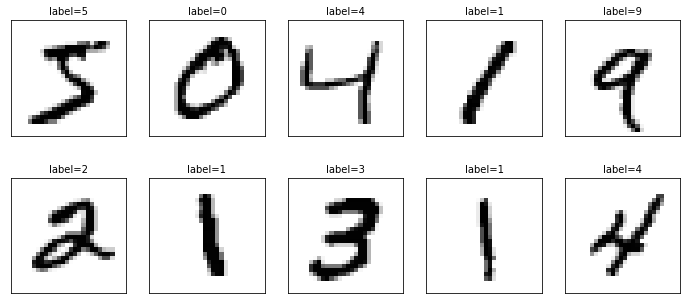

In [4]:
fig = plt.gcf()
fig.set_size_inches(12,14)

for i in range(0,10):
    ax=plt.subplot(5,5,1+i)
    ax.imshow(x_train[i], cmap='binary')
    title= "label=" +str(y_train[i])
    ax.set_title(title,fontsize=10) 
    ax.set_xticks([]);ax.set_yticks([])        
plt.show()

In [5]:
mean = np.mean(x_train) # take the mean
std = np.std(x_train)   # take the standard deviation
x_train = (x_train-mean)/(std+1e-7)    # normalizing the values
x_test = (x_test-mean)/(std+1e-7)

x_train = x_train.reshape(-1, 28, 28, 1) # reshaping them
x_test = x_test.reshape(-1, 28, 28, 1)

y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

### <b><span style="color:#27aee3; font-weight:1200">※</span> One-hot encoding & Validation Set
    

One-hot encoding is a process by which categorical targets are converted to a binary form (1's & 0's). The best way to understand is using an example. Suppose like in this set, there are 10 classes, each number representing the equivalent digit:

<h3 align='center'> [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ] </h3>
    
Now, once one-hot encoding is done using tensorflow, the result can be interpreted in the following way:
    
<b>Image at index 3</b>

<code>plt.imshow(x_train[3])</code>
    
which is the digit <b> 4 </b> (look in the coming cells). Now, to check the <code>y_train</code> for the answer, the result is as shown below:

<code>y_train[3]</code>
    
> $ \begin{bmatrix}
0., 0., 0., 0., 1., 0., 0., 0., 0., 0.  \\
\end{bmatrix}  $
    
Here, 0 means the digit is not present at this index while 1 means the digit is present at this index (which in this case is it's value). So, the above result means that the value is at index **4** which in this case is it's value.
    
Well, this may take a little time to wrap the head around :)

In [6]:
num_classes = 10

y_train = to_categorical(y_train, num_classes=num_classes)

x_train, x_val = x_train[:55000], x_train[55000:]
y_train, y_val = y_train[:55000], y_train[55000:]

print(f'Training samples: {x_train.shape}\nValidation samples: {x_val.shape}\nTesting samples: {x_test.shape}')

Training samples: (55000, 28, 28, 1)
Validation samples: (5000, 28, 28, 1)
Testing samples: (10000, 28, 28, 1)


# 4 <b><span style="color:#27aee3; font-weight:1200">|</span> CNN Model

In [7]:
nets = 1  # change here the amount of CNN ensembles
model = [0] * nets

for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))
    
    model[j].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    
model[0].summary() # summary of one of the models

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        25632     
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 32)       1

# 5 <b><span style="color:#27aee3; font-weight:1200">|</span> Data Augmentation

Neural Networks are data hungry. The more they are fed with, the more better they perform. Sometimes the data that is available is not that large, so in order to increase the amount of data fed, Data Augmentation is used.

Data Augmentation doesn't add new images to the present data but when they are passed to the network, along with them different variations of the images are also passed. Hence, we generate more images out of thin air!


<center><img src='https://i.gifer.com/origin/a5/a51dfe73c77cdcbac1b33fe8009bd0bc_w200.gif'></img></center>

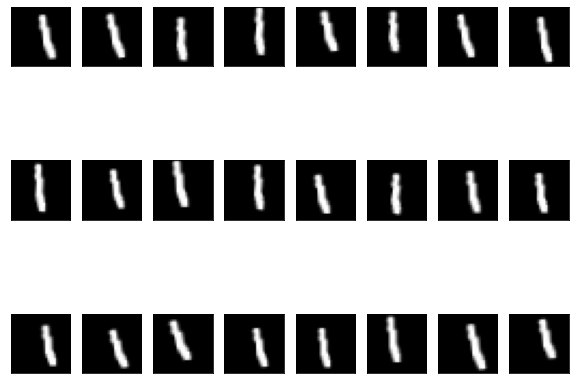

In [8]:
datagen = ImageDataGenerator(
                rotation_range=10,  
                zoom_range = 0.10,  
                width_shift_range=0.1, 
                height_shift_range=0.1
)

aug = datagen.flow(x_train[6].reshape(-1, 28, 28, 1))

fig = plt.figure(figsize=[10, 8])
for i in range(24):
    
    ax = fig.add_subplot(3, 8, i+1, xticks=[], yticks=[])
    aug_img = next(aug)[0]
    ax.imshow(aug_img, cmap = 'gray')
    
plt.show()

# 6 <b><span style="color:#27aee3; font-weight:1200">|</span> Network Training

LearningRateScheduler is used to update the learning rate with each new epoch.

In [9]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

hist = [0] * nets
epochs = 20
batch_size = 64

for j in range(nets):
    hist[j] = model[j].fit(
        datagen.flow(x_train, y_train, batch_size=batch_size), 
        epochs = epochs,
        steps_per_epoch=x_train.shape[0] // batch_size,
        validation_data = (x_val, y_val),
        callbacks = [annealer],
        verbose = 1)
    
    print(f'CNN {j+1}: Epochs = {epochs}, Training accuracy = {max(hist[j].history["accuracy"])}, Val accuracy = {max(hist[j].history["val_accuracy"])}')
    print()
    

Epoch 1/20
859/859 [==============================] - 88s 101ms/step - loss: 0.3752 - accuracy: 0.8855 - val_loss: 0.0386 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 2/20
859/859 [==============================] - 73s 85ms/step - loss: 0.1159 - accuracy: 0.9650 - val_loss: 0.0345 - val_accuracy: 0.9896 - lr: 9.5000e-04
Epoch 3/20
859/859 [==============================] - 74s 87ms/step - loss: 0.0869 - accuracy: 0.9730 - val_loss: 0.0320 - val_accuracy: 0.9914 - lr: 9.0250e-04
Epoch 4/20
859/859 [==============================] - 78s 91ms/step - loss: 0.0761 - accuracy: 0.9775 - val_loss: 0.0250 - val_accuracy: 0.9938 - lr: 8.5737e-04
Epoch 5/20
859/859 [==============================] - 75s 87ms/step - loss: 0.0645 - accuracy: 0.9810 - val_loss: 0.0267 - val_accuracy: 0.9930 - lr: 8.1451e-04
Epoch 6/20
859/859 [==============================] - 78s 91ms/step - loss: 0.0578 - accuracy: 0.9824 - val_loss: 0.0235 - val_accuracy: 0.9936 - lr: 7.7378e-04
Epoch 7/20
859/859 [=================

# 7 <b><span style="color:#27aee3; font-weight:1200">|</span> Ensembling Predictions
    

The results of all the CNN models are combined to get the maximun accuracy. 

<center><img src='https://editor.analyticsvidhya.com/uploads/990813.jpg'></img></center>

In [10]:
results = np.zeros((x_test.shape[0], 10))

for j in range(nets):
    results += model[j].predict(x_test)
    
results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1,28001), name="ImageId"), results], axis=1)
# submission.to_csv('sub.csv', index=False) # creating the submission file

# 8 <b><span style="color:#27aee3; font-weight:1200">|</span> Accuracy & Loss Plots

### <b><span style="color:#27aee3; font-weight:1200">※</span> Accuracy<br/>

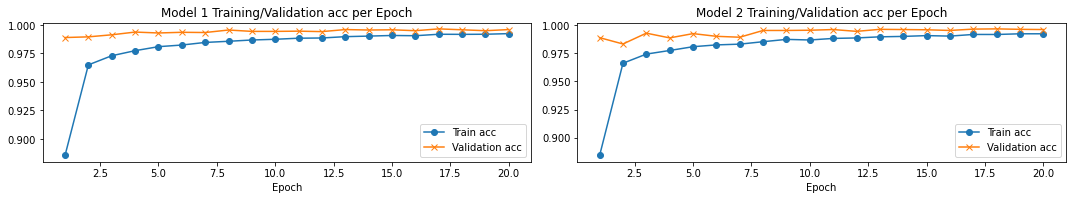

In [12]:
fig = plt.figure(figsize=[15, 10])

for i in range(2):
    ax = fig.add_subplot(4, 2, i+1)
    
    ax.plot([None] + hist[i].history['accuracy'], 'o-')
    ax.plot([None] + hist[i].history['val_accuracy'], 'x-')
    
    ax.legend(['Train acc', 'Validation acc'], loc = 0)
    ax.set_title(f'Model {i+1} Training/Validation acc per Epoch')
    ax.set_xlabel('Epoch')
    plt.tight_layout()

### <b><span style="color:#27aee3; font-weight:1200">※</span> Loss<br/>

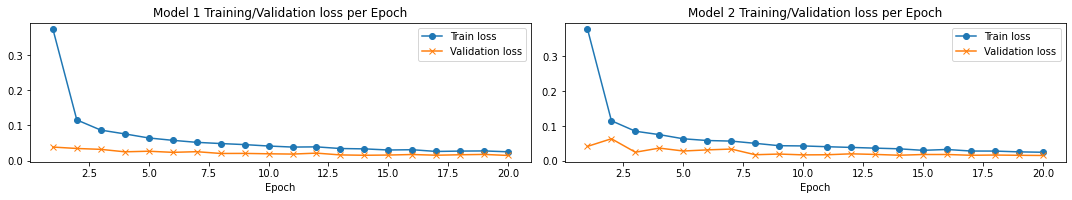

In [13]:
fig = plt.figure(figsize=[15, 10])

for i in range(2):
    ax = fig.add_subplot(4, 2, i+1)
    
    ax.plot([None] + hist[i].history['loss'], 'o-')
    ax.plot([None] + hist[i].history['val_loss'], 'x-')
    
    ax.legend(['Train loss', 'Validation loss'], loc = 0)
    ax.set_title(f'Model {i+1} Training/Validation loss per Epoch')
    ax.set_xlabel('Epoch')
    plt.tight_layout()

# 9 <b><span style="color:#27aee3; font-weight:1200">|</span> Some of the predictions

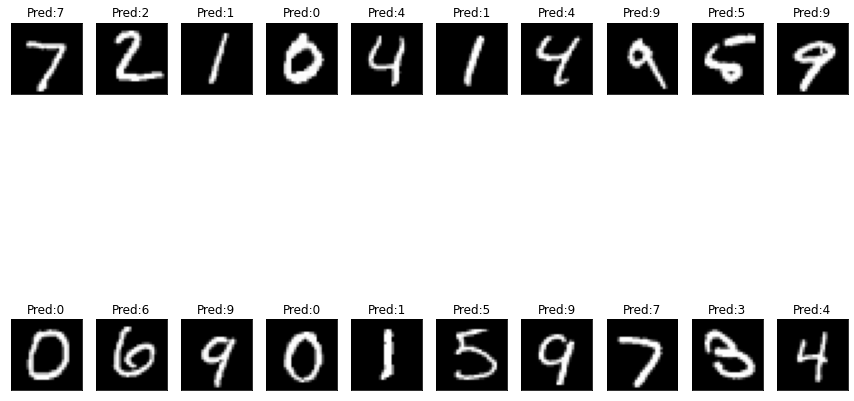

In [14]:
fig = plt.figure(figsize=[15, 10])


for i in range(20):
    img = x_test[i];
    ax = fig.add_subplot(2, 10, i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text(f'Pred:{results[i]}')
    plt.imshow(img, cmap='gray')
    
plt.show()

In [15]:
# save and load weights
model[1].save('my_model.h5')  
model[1].save_weights('my_model_weights.h5')
model[1].summary() # summary of one of the models

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_7 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 32)        25632     
                                                                 
 batch_normalization_9 (Batc  (None, 12, 12, 32)      

# 10 <b><span style="color:#27aee3; font-weight:1200">|</span> Acknowledgements
    
- https://www.kaggle.com/code/cdeotte/25-million-images-0-99757-mnist
- https://www.kaggle.com/code/samuelcortinhas/mnist-cnn-data-augmentation-99-6-accuracy

## Thanks for reading this. Would love to hear your views! 😄